In [138]:
# For this assignment, we have used Google Colab support to create the Visual Question Answering Model
# Mounting the Google Drive Folder

from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [139]:
# Installing the Required Modules for Modelling
!pip3 install --upgrade tensorflow-gpu
!pip install tensorflow --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [140]:
import os
import heapq
import pickle
import json
import warnings
import numpy as np
import random as rn
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.regularizers import l1,l2
import random 
import cv2
import seaborn as sns
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


- we have used 1000 training images and 100 validation images as asked and to also run the system

- Dataset is already Downloaded and placed in the /data folder.

- Training Images path: - ./data/train2014

- Validation Images path - ./data/val2014

- Both the questions json and annotations json files should be placed under the data folder for trainng and validation

### Count of Training and Validation Image Files

In [141]:
# Training FIle Path
training_files_path = "/content/drive/MyDrive/VisualQuestionAnswering/data/train2014/"
train_files = [f for f in os.listdir(training_files_path) if os.path.isfile(training_files_path + f)]
print("training files size", len(train_files))

training files size 1000


In [142]:
# Validation FIle Path
validation_files_path = "/content/drive/MyDrive/VisualQuestionAnswering/data/val2014/"
validation_files = [f for f in os.listdir(validation_files_path) if os.path.isfile(validation_files_path + f)]
print("validation files size", len(validation_files))

validation files size 100


### Loading and Merging Questions and Annotation Files

In [143]:
# Setting the path for training and validations questions and annotations json files
training_questions_file_path = "/content/drive/MyDrive/VisualQuestionAnswering/data/OpenEnded_mscoco_train2014_questions.json"
training_annotations_file_path = "/content/drive/MyDrive/VisualQuestionAnswering/data/mscoco_train2014_annotations.json"
validation_questions_file_path = "/content/drive/MyDrive/VisualQuestionAnswering/data/OpenEnded_mscoco_val2014_questions.json"
validation_annotations_file_path = "/content/drive/MyDrive/VisualQuestionAnswering/data/mscoco_val2014_annotations.json"

In [144]:
# Loading the "questions" list from the questions json file
with open(training_questions_file_path, "r") as file1:
    training_questions = json.load(file1)["questions"]
print("Total questions in training: ", len(training_questions))

Total questions in training:  248349


In [145]:
# Loading the "annotations" list from the annotations json file
with open(training_annotations_file_path, "r") as file2:
    training_annotations = json.load(file2)["annotations"]
print("Total annotations in training: ", len(training_annotations))

Total annotations in training:  248349


In [146]:
# Loading the "questions" list from the questions json file
with open(validation_questions_file_path, "r") as file3:
    validation_questions = json.load(file3)["questions"]
print("Total questions in validation: ", len(validation_questions))

Total questions in validation:  121512


In [147]:
# Loading the "annotations" list from the annotations json file
with open(validation_annotations_file_path, "r") as file4:
    validation_annotations = json.load(file4)["annotations"]
print("Total annotations in validation: ", len(validation_annotations))

Total annotations in validation:  121512


In [148]:
# Converting both the questions and annotations lists to Pandas DataFrames
training_questions_df = pd.DataFrame(training_questions)
training_annotations_df = pd.DataFrame(training_annotations)

In [149]:
# A peek at the questions_df
training_questions_df.head()

,question,image_id,question_id
0,What shape is the bench seat?,487025,4870250
1,Is there a shadow?,487025,4870251
2,Is this one bench or multiple benches?,487025,4870252
3,Is this a modern train?,78077,780770
4,What color is the stripe on the train?,78077,780771


In [150]:
# A peek at the annotaitons_df
training_annotations_df.head()

,question_type,multiple_choice_answer,answers,image_id,answer_type,question_id
0,what,curved,"[{'answer': 'oval', 'answer_confidence': 'yes'...",487025,other,4870250
1,is there a,yes,"[{'answer': 'yes', 'answer_confidence': 'yes',...",487025,yes/no,4870251
2,is this,1,"[{'answer': '1', 'answer_confidence': 'yes', '...",487025,other,4870252
3,is this a,no,"[{'answer': 'no', 'answer_confidence': 'yes', ...",78077,yes/no,780770
4,what color is the,white,"[{'answer': 'white', 'answer_confidence': 'yes...",78077,other,780771


In [151]:
# Converting both the questions and annotations lists to Pandas DataFrames
validation_questions_df = pd.DataFrame(validation_questions)
validation_annotations_df = pd.DataFrame(validation_annotations)

In [152]:
validation_questions_df.head()

,question,image_id,question_id
0,What is the table made of?,350623,3506232
1,Is the food napping on the table?,350623,3506230
2,What has been upcycled to make lights?,350623,3506231
3,Is this an Spanish town?,8647,86472
4,Are there shadows on the sidewalk?,8647,86470


In [153]:
validation_annotations_df.head()

,question_type,multiple_choice_answer,answers,image_id,answer_type,question_id
0,what is the,wood,"[{'answer': 'wood', 'answer_confidence': 'yes'...",350623,other,3506232
1,is the,no,"[{'answer': 'no', 'answer_confidence': 'yes', ...",350623,yes/no,3506230
2,what,kettles,"[{'answer': 'kettles', 'answer_confidence': 'y...",350623,other,3506231
3,is this an,no,"[{'answer': 'yes', 'answer_confidence': 'maybe...",8647,yes/no,86472
4,are there,yes,"[{'answer': 'yes', 'answer_confidence': 'yes',...",8647,yes/no,86470


In [154]:
# Here we are merging both the questions and annotations dataframes on the image_id and question_id columns
training_data = pd.merge(training_questions_df,
                         training_annotations_df,
                         how="inner",
                         left_on=["image_id", "question_id"], 
                         right_on=["image_id", "question_id"])

In [155]:
validation_data = pd.merge(validation_questions_df, 
                           validation_annotations_df,
                           how="inner", 
                           left_on=["image_id", "question_id"], 
                           right_on=["image_id", "question_id"])

In [156]:
# A peek at the merged Dataset
training_data.head()

,question,image_id,question_id,question_type,multiple_choice_answer,answers,answer_type
0,What shape is the bench seat?,487025,4870250,what,curved,"[{'answer': 'oval', 'answer_confidence': 'yes'...",other
1,Is there a shadow?,487025,4870251,is there a,yes,"[{'answer': 'yes', 'answer_confidence': 'yes',...",yes/no
2,Is this one bench or multiple benches?,487025,4870252,is this,1,"[{'answer': '1', 'answer_confidence': 'yes', '...",other
3,Is this a modern train?,78077,780770,is this a,no,"[{'answer': 'no', 'answer_confidence': 'yes', ...",yes/no
4,What color is the stripe on the train?,78077,780771,what color is the,white,"[{'answer': 'white', 'answer_confidence': 'yes...",other


In [157]:
# A peek at the merged Dataset
validation_data.head()

,question,image_id,question_id,question_type,multiple_choice_answer,answers,answer_type
0,What is the table made of?,350623,3506232,what is the,wood,"[{'answer': 'wood', 'answer_confidence': 'yes'...",other
1,Is the food napping on the table?,350623,3506230,is the,no,"[{'answer': 'no', 'answer_confidence': 'yes', ...",yes/no
2,What has been upcycled to make lights?,350623,3506231,what,kettles,"[{'answer': 'kettles', 'answer_confidence': 'y...",other
3,Is this an Spanish town?,8647,86472,is this an,no,"[{'answer': 'yes', 'answer_confidence': 'maybe...",yes/no
4,Are there shadows on the sidewalk?,8647,86470,are there,yes,"[{'answer': 'yes', 'answer_confidence': 'yes',...",yes/no


- As mentioned earlier, we are only consiering 1000 images for training the model, hence subsetting the same form the data dataframe.

In [158]:
# Subset Questions and Annotations for the 1000 training Images
train_image_ids_list = list(set(training_data["image_id"].values))
training_image_ids = [image_id for image_id in train_image_ids_list if "COCO_train2014_" + "%012d.jpg" % (image_id) in train_files]
print("Total Images in the training_image_ids: ", len(training_image_ids))

Total Images in the training_image_ids:  1000


In [159]:
# Subset Questions and Annotations for the 1000 training Images
validation_image_ids_list = list(set(validation_data["image_id"].values))
validation_image_ids = [image_id for image_id in validation_image_ids_list if "COCO_val2014_" + "%012d.jpg" % (image_id) in validation_files]
print("Total Images in the validation_image_ids: ", len(validation_image_ids))

Total Images in the validation_image_ids:  100


In [160]:
train_df = training_data[training_data["image_id"].isin(training_image_ids)].reset_index(drop=True)
val_df = validation_data[validation_data["image_id"].isin(validation_image_ids)].reset_index(drop=True)

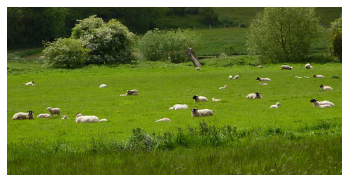

**************************************************
Question:  Does it appear that it is a clear day?
**************************************************
Answer:  yes
(251, 500, 3)


In [161]:
# Randomly Displaying an Image, Question and its Answer
index = np.random.randint(0, len(train_df))

img_path =  "/content/drive/MyDrive/VisualQuestionAnswering/data/train2014/" + "COCO_train2014_" + "%012d.jpg" % (train_df["image_id"][index])

img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.axis("off")
plt.show()

print("*"*50)
print("Question: ", train_df["question"][index])
print("*"*50)
print("Answer: ", train_df["multiple_choice_answer"][index])
print(img.shape)

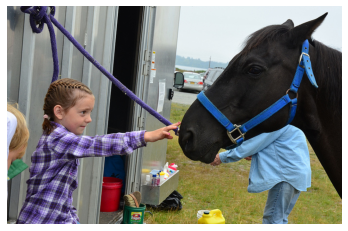

**************************************************
Question:  What is the kid petting?
**************************************************
Answer:  horse
(416, 640, 3)


In [162]:
# Randomly Displaying a Validation Image, Question and its Answer
index = np.random.randint(0, len(val_df))

img_path =  "/content/drive/MyDrive/VisualQuestionAnswering/data/val2014/" + "COCO_val2014_" + "%012d.jpg" % (val_df["image_id"][index])

img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.axis("off")
plt.show()

print("*"*50)
print("Question: ", val_df["question"][index])
print("*"*50)
print("Answer: ", val_df["multiple_choice_answer"][index])
print(img.shape)

In [163]:
def convert_people_answer(answers):
    answers_dict = {}
    score_dict = {"yes" : 3, "maybe" : 2, "no" : 1 }
    
    for _answer in answers:
        score = score_dict[_answer["answer_confidence"]]
        if answers_dict.get(_answer["answer"],-1) != -1 :
            answers_dict[_answer["answer"]] += score
        else:
            answers_dict[_answer["answer"]] = score

    return sorted(list(answers_dict.items()),key = lambda x: x[1],reverse=True)[0][0]

In [164]:
# Changing the number of people to yes, maybe or no style of answer
train_df["derived_answer"] =  train_df["answers"].apply(lambda x: convert_people_answer(x))

val_df["derived_answer"] =  val_df["answers"].apply(lambda x: convert_people_answer(x))

In [165]:
train_df.to_csv("/content/drive/MyDrive/VisualQuestionAnswering/data/train_df.csv", index=False)
val_df.to_csv("/content/drive/MyDrive/VisualQuestionAnswering/data/val_df.csv", index=False)

Model  - encoding model, development, decoing 


In [166]:
BATCH_SIZE, BUFFER_SIZE = 64, 300
image_width, image_height = 224, 224

In [167]:
data_directory = "/content/drive/MyDrive/VisualQuestionAnswering/data/"

train_image_directory = "/content/drive/MyDrive/VisualQuestionAnswering/data/train2014/"
val_image_directory = "/content/drive/MyDrive/VisualQuestionAnswering/data/val2014/"


image_width, image_height = 224, 224
BATCH_SIZE, BUFFER_SIZE = 64, 300

In [168]:
training_df_path = "/content/drive/MyDrive/VisualQuestionAnswering/data/train_df.csv"
validation_df_path = "/content/drive/MyDrive/VisualQuestionAnswering/data/val_df.csv"


train_df = pd.read_csv(training_df_path)
val_df = pd.read_csv(validation_df_path)

#X_train, X_val = train_test_split(train_df, test_size=0.2, random_state=42)

In [169]:
X_train = train_df
X_val = val_df

In [170]:
X_train.shape, X_val.shape

((3000, 8), (300, 8))

In [171]:
contractions = { "ain't": "am not",
                "aren't": "are not",
                "can't": "cannot",
                "can't've": "cannot have",
                "'cause": "because",
                "could've": "could have",
                "couldn't": "could not",
                "couldn't've": "could not have",
                "didn't": "did not",
                "doesn't": "does not",
                "don't": "do not",
                "hadn't": "had not",
                "hadn't've": "had not have",
                "hasn't": "has not",
                "haven't": "have not",
                "he'd": "he would",
                "he'd've": "he would have",
                "he'll": "he will",
                "he's": "he is",
                "how'd": "how did",
                "how'll": "how will",
                "how's": "how is",
                "i'd": "i would",
                "i'll": "i will",
                "i'm": "i am",
                "i've": "i have",
                "isn't": "is not",
                "it'd": "it would",
                "it'll": "it will",
                "it's": "it is",
                "let's": "let us",
                "ma'am": "madam",
                "mayn't": "may not",
                "might've": "might have",
                "mightn't": "might not",
                "must've": "must have",
                "mustn't": "must not",
                "needn't": "need not",
                "oughtn't": "ought not",
                "shan't": "shall not",
                "sha'n't": "shall not",
                "she'd": "she would",
                "she'll": "she will",
                "she's": "she is",
                "should've": "should have",
                "shouldn't": "should not",
                "that'd": "that would",
                "that's": "that is",
                "there'd": "there had",
                "there's": "there is",
                "they'd": "they would",
                "they'll": "they will",
                "they're": "they are",
                "they've": "they have",
                "wasn't": "was not",
                "we'd": "we would",
                "we'll": "we will",
                "we're": "we are",
                "we've": "we have",
                "weren't": "were not",
                "what'll": "what will",
                "what're": "what are",
                "what's": "what is",
                "what've": "what have",
                "where'd": "where did",
                "where's": "where is",
                "who'll": "who will",
                "who's": "who is",
                "won't": "will not",
                "wouldn't": "would not",
                "you'd": "you would",
                "you'll": "you will",
                "you're": "you are"}

def preprocess_english(text):
    '''Given a text this function removes the punctuations and returns the remaining text string'''
    new_text = ""
    text = text.lower()
    i = 0
    for word in text.split():
      if i==0:
        new_text = contractions.get(word,word)
      else:
        new_text = new_text + " " + contractions.get(word,word)
      i += 1
    return new_text.replace("'s", '')

In [172]:
X_train["multiple_choice_answer"] = X_train["multiple_choice_answer"].apply(lambda x: preprocess_english(x))
X_val["multiple_choice_answer"] = X_val["multiple_choice_answer"].apply(lambda x: preprocess_english(x))

In [173]:
all_classes = X_train["multiple_choice_answer"].values
class_frequency = {}

for _cls in all_classes:
    if(class_frequency.get(_cls,-1)>0):
        class_frequency[_cls] += 1
    else:
        class_frequency[_cls] = 1

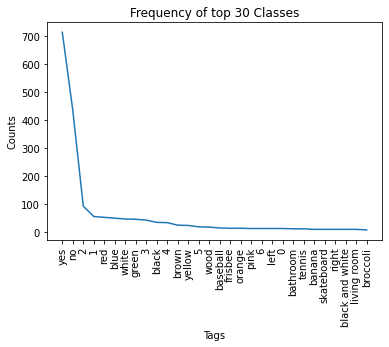

In [174]:
sort_class_frequency = sorted(list(class_frequency.items()), key = lambda x: x[1], reverse=True)   

plt.plot([x[1] for x in sort_class_frequency[:30]])
i=np.arange(30)
plt.title("Frequency of top 30 Classes")
plt.xlabel("Tags")
plt.ylabel("Counts")
plt.xticks(i,[x[0] for x in sort_class_frequency[:30]])
plt.xticks(rotation=90)
plt.show()

5 most frequent Classes covers 44.93% points
10 most frequent Classes covers 52.13% points
20 most frequent Classes covers 58.10% points
50 most frequent Classes covers 65.27% points
70 most frequent Classes covers 68.13% points
100 most frequent Classes covers 71.30% points
200 most frequent Classes covers 78.50% points
500 most frequent Classes covers 89.23% points
750 most frequent Classes covers 97.57% points
1000 most frequent Classes covers 100.00% points
2000 most frequent Classes covers 100.00% points
3000 most frequent Classes covers 100.00% points
5000 most frequent Classes covers 100.00% points


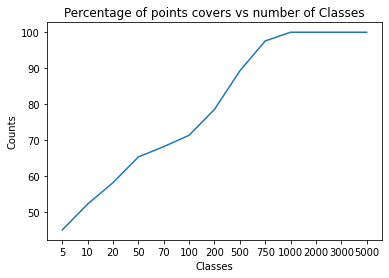

In [175]:
def getPercentageOfDataCoversGivenNumClasses(n_class, class_frequency, df):
    n_common_class = heapq.nlargest(n_class, class_frequency, key=class_frequency.get)
    count = 0
    for _class in df["multiple_choice_answer"].values:
        if(_class in n_common_class):
            count += 1

    return (count/len(df))*100
    
n_classes = [5, 10, 20, 50, 70, 100, 200, 500, 750, 1000, 2000, 3000, 5000]
percentage_cover = []
for i in n_classes:
    temp = getPercentageOfDataCoversGivenNumClasses(i,class_frequency,X_train)
    percentage_cover.append(temp)
    print("{} most frequent Classes covers {:.2f}% points".format(i,temp))


plt.plot(percentage_cover)
i=np.arange(len(percentage_cover))
plt.title("Percentage of points covers vs number of Classes")
plt.xlabel("Classes")
plt.ylabel("Counts")
plt.xticks(i,n_classes)
plt.show()

In [176]:
common_tags = heapq.nlargest(1000, class_frequency, key = class_frequency.get)
X_train["multiple_choice_answer"] =  X_train["multiple_choice_answer"].apply(lambda x: x if x in common_tags else '')

# removing question which has empty tags
X_train = X_train[X_train["multiple_choice_answer"].apply(lambda x: len(x)>0)]

In [177]:
label_encoder = LabelBinarizer()
answer_vector_train = label_encoder.fit_transform(X_train['multiple_choice_answer'].apply(lambda x: x).values)
answer_vector_val = label_encoder.transform(X_val['multiple_choice_answer'].apply(lambda x: x).values)

ans_vocab = {l: i for i, l in enumerate(label_encoder.classes_)}

print("Number of clasess: ", len(ans_vocab))

Number of clasess:  823


Creating Image Features using VGG19

In [178]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (image_width, image_height))
    img = tf.keras.applications.vgg19.preprocess_input(img)
    img = img * (1./255)
    return img, image_path

In [179]:
def VGG19_Top():
    model = tf.keras.applications.VGG19(include_top=False, weights="imagenet", input_shape=(image_width, image_height, 3))
    input_layer = model.input
    hidden_layer = model.layers[-1].output 
    model = tf.keras.Model(input_layer, hidden_layer)
    return model

In [180]:
def generateImageFeatures(images, filename):
    model = VGG19_Top()
    all_image_dict = {}
    img_ds = tf.data.Dataset.from_tensor_slices(images)
    img_ds = img_ds.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

    for batch_img, batch_path in img_ds:
        batch_img_features = model(batch_img)

        for img_features, path in zip(batch_img_features, batch_path):
            image_path = path.numpy().decode("utf-8")
            #image_path = image_path.replace(imageDirectory,imageNumpyDirectory).replace('.jpg',"")
            #np.save(image_path, img_features.numpy())
            all_image_dict[image_path] = img_features.numpy()

    with open(data_directory + filename, "wb") as handle:
        pickle.dump(all_image_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("Pickled Data")
    return

In [181]:
train_all_image_path = train_df["image_id"].apply(lambda x:  train_image_directory + "COCO_train2014_" + "%012d.jpg" % (x)).unique()
val_all_image_path = val_df["image_id"].apply(lambda x:  val_image_directory + "COCO_val2014_" + "%012d.jpg" % (x)).unique()

In [182]:
train_all_image_path[0], val_all_image_path[0]

('/content/drive/MyDrive/VisualQuestionAnswering/data/train2014/COCO_train2014_000000136653.jpg',
 '/content/drive/MyDrive/VisualQuestionAnswering/data/val2014/COCO_val2014_000000149222.jpg')

In [183]:
generateImageFeatures(train_all_image_path, "train_all_image_dict.pickle")
generateImageFeatures(val_all_image_path, "val_all_image_dict.pickle")

Pickled Data
Pickled Data


In [184]:
X_train.to_csv("/content/drive/MyDrive/VisualQuestionAnswering/data/X_train.csv", index=False)
X_val.to_csv("/content/drive/MyDrive/VisualQuestionAnswering/data/X_val.csv", index=False)

In [185]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [186]:
image_paths_train = X_train["image_id"].apply(lambda x:  train_image_directory + "COCO_train2014_" + "%012d.jpg" % (x)).values
image_paths_val = X_val["image_id"].apply(lambda x:  val_image_directory + "COCO_val2014_" + "%012d.jpg" % (x)).values

with open(data_directory + "train_all_image_dict.pickle", "rb") as handle:
    train_all_image_dict = pickle.load(handle)

with open(data_directory + "val_all_image_dict.pickle", "rb") as handle:
    val_all_image_dict = pickle.load(handle)

In [187]:
#tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token = "", filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(X_train['question'].values)
train_question_seqs = tokenizer.texts_to_sequences(X_train['question'].values)
val_question_seqs = tokenizer.texts_to_sequences(X_val['question'].values)

print("Number of words in tokenizer:", len(tokenizer.word_index))
ques_vocab = tokenizer.word_index

#Padding
#tokenizer.word_index[''] = 0
#tokenizer.index_word[0] = ''
question_vector_train = tf.keras.preprocessing.sequence.pad_sequences(train_question_seqs, padding='post')
question_vector_val = tf.keras.preprocessing.sequence.pad_sequences(val_question_seqs,padding='post',maxlen=question_vector_train.shape[1])


Number of words in tokenizer: 1990


In [188]:
def get_train_image_tensor(img, ques):
    #path = img.decode('utf-8').replace(imageDirectory,imageNumpyDirectory).replace('.jpg',"") +'.npy'
    #img_tensor = np.load(path)
    img_tensor = train_all_image_dict[img.decode('utf-8')]
    return img_tensor, ques

In [189]:
def get_valid_image_tensor(img, ques):
    #path = img.decode('utf-8').replace(imageDirectory,imageNumpyDirectory).replace('.jpg',"") +'.npy'
    #img_tensor = np.load(path)
    img_tensor = val_all_image_dict[img.decode('utf-8')]
    return img_tensor, ques

In [190]:
def createDataset(image_paths, question_vector, answer_vector, image_tensor_method):
    dataset_input = tf.data.Dataset.from_tensor_slices((image_paths, question_vector.astype(np.float32)))
    
    dataset_output = tf.data.Dataset.from_tensor_slices((answer_vector.astype(np.float32)))
    
    dataset_input = dataset_input.map(lambda img, ques : tf.numpy_function(image_tensor_method, 
                                                                           [img, ques], 
                                                                           [tf.float32, tf.float32]),
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # shuffling and batching
    #dataset_input = dataset_input.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    dataset_input = dataset_input.batch(BATCH_SIZE)
    dataset_output = dataset_output.batch(BATCH_SIZE)#.repeat()
    
    dataset = tf.data.Dataset.zip((dataset_input, dataset_output))
    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

    return dataset

In [191]:
label_encoder = LabelBinarizer()
answer_vector_train = label_encoder.fit_transform(X_train['multiple_choice_answer'].apply(lambda x: x).values)
answer_vector_val = label_encoder.transform(X_val['multiple_choice_answer'].apply(lambda x: x).values)

ans_vocab = {l: i for i, l in enumerate(label_encoder.classes_)}

print("Number of clasess: ", len(ans_vocab))

Number of clasess:  823


In [192]:
dataset_train = createDataset(image_paths_train, question_vector_train, answer_vector_train, get_train_image_tensor)
dataset_val = createDataset(image_paths_val, question_vector_val, answer_vector_val, get_valid_image_tensor)

In [193]:
##fixing numpy RS
np.random.seed(42)

##fixing tensorflow RS
tf.random.set_seed(32)

##python RS
rn.seed(12)

In [194]:
def Build_BaseModel():
    image_input = tf.keras.layers.Input(shape=(7,7,512))
    question_input = tf.keras.layers.Input(shape=(question_vector_train.shape[1],))

    image_conv_layer1 = tf.keras.layers.Conv2D(filters = 4096, kernel_size = 7 , strides = 1, padding = "valid", activation = 'relu',
                                               kernel_initializer = tf.keras.initializers.he_normal(seed=45))(image_input)

    image_flatten = tf.keras.layers.Flatten()(image_conv_layer1)

    image_dense_1 = tf.keras.layers.Dense(4096, activation = tf.nn.relu, 
                                          kernel_initializer = tf.keras.initializers.he_uniform(seed=54))(image_flatten)
    
    image_dense_2 = tf.keras.layers.Dense(1024, activation = tf.nn.relu, 
                                          kernel_initializer = tf.keras.initializers.he_uniform(seed=32))(image_dense_1)


    # Input 2 Pathway
    question_emb = tf.keras.layers.Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim=300, name = "Embedding_Layer",
                                             embeddings_initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=1, seed=23))(question_input)

    question_lstm = tf.keras.layers.LSTM(1024, 
                                         kernel_initializer = tf.keras.initializers.glorot_uniform(seed=26),
                                         recurrent_initializer = tf.keras.initializers.orthogonal(seed=54),
                                         bias_initializer=tf.keras.initializers.zeros())(question_emb)

    question_flatten = tf.keras.layers.Flatten(name="Flatten_lstm")(question_lstm)

    
    image_question = tf.keras.layers.Multiply()([image_dense_2, question_flatten])


    image_question_dense_1 = tf.keras.layers.Dense(1000, activation = tf.nn.relu,
                                                    kernel_initializer = tf.keras.initializers.he_uniform(seed=19))(image_question)
    
    image_question_dense_2 = tf.keras.layers.Dense(1000, activation = tf.nn.relu, 
                                                   kernel_initializer = tf.keras.initializers.he_uniform(seed=28))(image_question_dense_1)

    output = tf.keras.layers.Dense(len(ans_vocab), activation=tf.nn.softmax, 
                                   kernel_initializer = tf.keras.initializers.glorot_normal(seed=15))(image_question_dense_2)

    # Create Model
    model = tf.keras.models.Model(inputs = [image_input, question_input], outputs = output)
    
    # Compile
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [195]:
import warnings
warnings.filterwarnings("ignore")

l2_alpha = 0.01

ModelName = "BaselineModel"

model = Build_BaseModel()

history = model.fit(dataset_train, epochs=10, validation_data=dataset_val)

Epoch 1/10
47/47 [==============================] - 8s 95ms/step - loss: 6.4580 - accuracy: 0.2033 - val_loss: 3.2420 - val_accuracy: 0.2433
Epoch 2/10
47/47 [==============================] - 1s 30ms/step - loss: 4.7301 - accuracy: 0.2300 - val_loss: 3.1859 - val_accuracy: 0.2433
Epoch 3/10
47/47 [==============================] - 1s 30ms/step - loss: 4.8177 - accuracy: 0.2360 - val_loss: 3.3600 - val_accuracy: 0.2433
Epoch 4/10
47/47 [==============================] - 1s 30ms/step - loss: 4.5603 - accuracy: 0.2380 - val_loss: 2.6527 - val_accuracy: 0.2433
Epoch 5/10
47/47 [==============================] - 1s 30ms/step - loss: 4.1206 - accuracy: 0.2387 - val_loss: 2.5845 - val_accuracy: 0.2433
Epoch 6/10
47/47 [==============================] - 1s 30ms/step - loss: 3.9291 - accuracy: 0.2430 - val_loss: 2.4070 - val_accuracy: 0.2633
Epoch 7/10
47/47 [==============================] - 1s 30ms/step - loss: 3.6907 - accuracy: 0.2577 - val_loss: 2.3379 - val_accuracy: 0.2633
Epoch 8/10
47

In [196]:
model.save_weights("/MyDrive/VisualQuestionAnswering/Model/model4.h5f")

In [197]:
model.load_weights("/MyDrive/VisualQuestionAnswering/Model/model4.h5f")

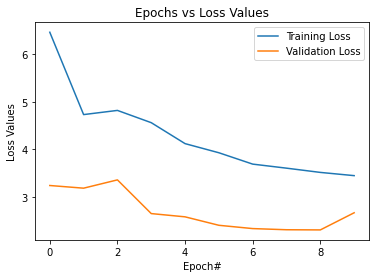

In [198]:
# Plotting the Training and Validation Loss Scores for the 10 Epochs

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch#")
plt.ylabel("Loss Values")
plt.title("Epochs vs Loss Values")
plt.legend()
plt.show()

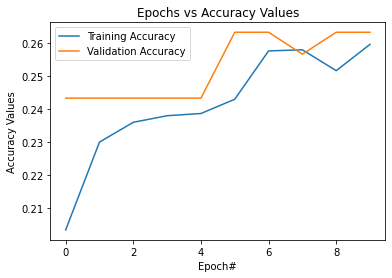

In [199]:
# Plotting the Training and Validation Accuracy Scores for the 10 Epochs

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch#")
plt.ylabel("Accuracy Values")
plt.title("Epochs vs Accuracy Values")
plt.legend()
plt.show()

In [200]:
sample_list1 = list(range(len(image_paths_val)))

random_30_indices = rn.sample(sample_list1,30)


In [201]:
def show_heatmap_of_images(image_path):
  actual_image = image.load_img(image_path, target_size=(299, 299))
  actual_image_array = image.img_to_array(actual_image)
  actual_image_array = np.expand_dims(actual_image_array, axis=0)
  preprocessed_image_array = preprocess_input(actual_image_array)
  inception_predictions = incep_model.predict(preprocessed_image_array)
  
  with tf.GradientTape() as gradient_value:
    convolution_layer = incep_model.get_layer("conv2d_211")
    heatmap_model = tf.keras.models.Model([incep_model.inputs], [incep_model.output, convolution_layer.output])
    model_output, convolution_layer = heatmap_model(preprocessed_image_array)
    model_predictions = model_output[:, np.argmax(model_output[0])]
    grad_value = gradient_value.gradient(model_predictions, convolution_layer)  
    pool_grad_value = K.mean(grad_value, axis=(0, 1, 2))
  
  heat_map = tf.reduce_mean(tf.multiply(pool_grad_value, convolution_layer), axis=-1)
  heat_map = np.maximum(heat_map, 0)
  heat_map /= np.max(heat_map)
  heat_map = heat_map.reshape((1, 35, 35)).flatten()
  
  # Read the images using CV2 imread
  image_data = cv2.imread(image_path)
  
  # Resize the heatmap
  image_heat_map = cv2.resize(heat_map, (image_data.shape[1], image_data.shape[0]))
  image_heat_map = cv2.applyColorMap(np.uint8(255*image_heat_map), cv2.COLORMAP_JET)
  image_data = image_heat_map * 0.7 + image_data
  
  # Display the Heatmap
  cv2_imshow(cv2.resize(image_data, (299, 299)))

  return

In [202]:
from sklearn.metrics.pairwise import cosine_similarity

def show_attention_map(tokenized_labels_arr, tokenized_labels):
  cosine_sim_output = cosine_similarity(tokenized_labels_arr)
  cosine_sim_output = pd.DataFrame(cosine_sim_output)
  cosine_sim_output.index, cosine_sim_output.columns = tokenized_labels, tokenized_labels
  fig, ax = plt.subplots(figsize=(5, 5))
  sns.heatmap(cosine_sim_output, cmap="YlGnBu")
  return

In [203]:
# Using Inception Model with ImageNet weights for HeatMap Visualization
incep_model = InceptionV3(weights="imagenet")

incep_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_191 (Conv2D)            (None, 149, 149, 32  864         ['input_15[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 149, 149, 32  96         ['conv2d_191[0][0]']             
 Normalization)                 )                                                      

In [205]:
val_predictions = []

for index in random_30_indices:
  print("Image Index: ", index)
  print("***Plotting the Image***")
  img = mpimg.imread(image_paths_val[index])
  imgplot = plt.imshow(img)
  plt.axis("off")
  plt.show()
  print("***Question***")
  print(val_df.loc[index, "question"])

  img_tensor, ques = val_all_image_dict[image_paths_val[index]], question_vector_val[index].astype(np.float32)

  test_image_features = img_tensor
  test_question_features = ques.reshape(1, -1)

  y_pred = model.predict([test_image_features.reshape(1,7, 7, 512), test_question_features])

  class_indices = tf.math.top_k(y_pred, k=1).indices.numpy()
  percentages = tf.math.top_k(y_pred, k=1).values.numpy()[0] * 100

  predictions = []
  for idx, i in enumerate(class_indices[0]):
    classes = np.zeros((1, 1000))
    classes[0][i] = 1
    predictions.append((label_encoder.inverse_transform(classes)[0],percentages[idx]))
  val_predictions.append(predictions)

  print("***Ground Truth Answer***: ", val_df.loc[index, "multiple_choice_answer"])
  print("***Predicted Answer***: ", predictions[0][0])
  print("***Confidence with which the Prediction is made**: ", predictions[0][1])


  print("***Image HeatMap***")
  show_heatmap_of_images(image_paths_val[index])

  print("***Attention Correlation Visualization***")
  question_text = val_df.loc[index, "question"]
  tokenized_question = question_text.split()
  tokenized_labels = [token for token in tokenized_question]
  
  vectorizer = CountVectorizer()
  tokenized_labels_arr = vectorizer.fit_transform(tokenized_labels).toarray()
  show_attention_map(tokenized_labels_arr, tokenized_labels)
  plt.show()

  print("*****************************************************************************")
  print("\n")

Output hidden; open in https://colab.research.google.com to view.